# Logistic Regression using Twitter Bot data
### Import libraries

In [215]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# NLP library (pretrained option for sentiment analysis)
from nltk.sentiment import SentimentIntensityAnalyzer
# library for extracting text features
import textfeatures as tf

# statsmodels - evaluate if logistic regression requirements are met
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.genmod.generalized_linear_model import GLM
from statsmodels.genmod import families

# statsmodels - build model
from statsmodels.tools.tools import add_constant
from statsmodels.discrete.discrete_model import Logit

# sklearn - build model
from sklearn.linear_model import LogisticRegression

# sklearn - prep data
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# sklearn - evaluate
from sklearn.metrics import (confusion_matrix, accuracy_score)
from sklearn.metrics import classification_report
from sklearn.metrics import log_loss
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import RFE

### Load and clean data
The initial data is pretty clean. From looking at the tweets, it appears the text was already cleaned and stopwords were removed.

In [12]:
twitter_bot_data = pd.read_csv('bot_detection_data.csv')
twitter_bot_data

,User ID,Username,Tweet,Retweet Count,Mention Count,Follower Count,Verified,Bot Label,Location,Created At,Hashtags
0,132131,flong,Station activity person against natural majori...,85,1,2353,False,1,Adkinston,2020-05-11 15:29:50,NaN
1,289683,hinesstephanie,Authority research natural life material staff...,55,5,9617,True,0,Sanderston,2022-11-26 05:18:10,both live
2,779715,roberttran,Manage whose quickly especially foot none to g...,6,2,4363,True,0,Harrisonfurt,2022-08-08 03:16:54,phone ahead
3,696168,pmason,Just cover eight opportunity strong policy which.,54,5,2242,True,1,Martinezberg,2021-08-14 22:27:05,ever quickly new I
4,704441,noah87,Animal sign six data good or.,26,3,8438,False,1,Camachoville,2020-04-13 21:24:21,foreign mention
...,...,...,...,...,...,...,...,...,...,...,...
49995,491196,uberg,Want but put card direction know miss former h...,64,0,9911,True,1,Lake Kimberlyburgh,2023-04-20 11:06:26,teach quality ten education any
49996,739297,jessicamunoz,Provide whole maybe agree church respond most ...,18,5,9900,False,1,Greenbury,2022-10-18 03:57:35,add walk among believe
49997,674475,lynncunningham,Bring different everyone international capital...,43,3,6313,True,1,Deborahfort,2020-07-08 03:54:08,onto admit artist first
49998,167081,richardthompson,Than about single generation itself seek sell ...,45,1,6343,False,0,Stephenside,2022-03-22 12:13:44,star


#### Check for null values

In [13]:
# checking for null values
twitter_bot_data.isna().sum()

User ID              0
Username             0
Tweet                0
Retweet Count        0
Mention Count        0
Follower Count       0
Verified             0
Bot Label            0
Location             0
Created At           0
Hashtags          8341
dtype: int64

In [18]:
# filtering the rows where Hashtags is NaN
nulls = twitter_bot_data[twitter_bot_data['Hashtags'].isna()]
nulls

,User ID,Username,Tweet,Retweet Count,Mention Count,Follower Count,Verified,Bot Label,Location,Created At,Hashtags
0,132131,flong,Station activity person against natural majori...,85,1,2353,False,1,Adkinston,2020-05-11 15:29:50,NaN
8,549888,kimberlymorris,Eye rest prove mission show floor.,25,2,836,False,0,Lake Brittanyville,2021-12-19 19:00:16,NaN
10,576805,hicksanthony,Through both practice point fear billion deep.,57,4,8694,False,1,Harrisbury,2020-08-30 10:04:51,NaN
12,383629,rcruz,Recognize nor choose over trade another involve.,60,2,6779,False,0,Juliehaven,2021-06-13 22:03:42,NaN
20,463487,hernandezchristian,Part admit the choice across some data edge ag...,26,4,653,True,1,Lake Jose,2020-04-20 11:42:06,NaN
...,...,...,...,...,...,...,...,...,...,...,...
49963,816692,kryan,Decision history mind other marriage song.,97,3,5787,True,0,East Rossmouth,2021-08-08 02:08:14,NaN
49968,425860,wmoss,Right Mrs coach imagine they source carry.,15,2,6286,True,1,New Suzanneburgh,2020-08-18 12:41:51,NaN
49988,279336,smithjohn,Pressure focus do five consumer then effect in...,41,1,2366,False,0,Whitneyland,2022-12-31 04:41:23,NaN
49990,312961,princeanita,Administration country big gun still writer be...,5,1,8053,True,0,New Ericbury,2021-06-02 09:02:39,NaN


In [23]:
# there are too many distinct values for Hashtag to use for this model so will not need to drop the nulls
twitter_bot_data.Hashtags.value_counts

<bound method IndexOpsMixin.value_counts of 0                                    NaN
1                              both live
2                            phone ahead
3                     ever quickly new I
4                        foreign mention
                      ...               
49995    teach quality ten education any
49996             add walk among believe
49997            onto admit artist first
49998                               star
49999                               home
Name: Hashtags, Length: 50000, dtype: object>

In [26]:
# also too many locations to use
twitter_bot_data.Location.value_counts

<bound method IndexOpsMixin.value_counts of 0                 Adkinston
1                Sanderston
2              Harrisonfurt
3              Martinezberg
4              Camachoville
                ...        
49995    Lake Kimberlyburgh
49996             Greenbury
49997           Deborahfort
49998           Stephenside
49999             Novakberg
Name: Location, Length: 50000, dtype: object>

In [74]:
# drops any duplicate rows
twitter_bot_data.drop_duplicates(inplace=True)

### Feature Engineering

SOURCE: https://towardsdatascience.com/textfeatures-library-for-extracting-basic-features-from-text-data-f98ba90e3932 \
SOURCE: https://realpython.com/python-nltk-sentiment-analysis/

In [88]:
tf.word_count(twitter_bot_data, 'Tweet', 'Tweet_word_count')
tf.char_count(twitter_bot_data, 'Tweet', 'Tweet_char_count')
tf.avg_word_length(twitter_bot_data, 'Tweet', 'Tweet_avg_word_length')
twitter_bot_data.head()

,User ID,Username,Tweet,Retweet Count,Mention Count,Follower Count,Verified,Bot Label,Location,Created At,Hashtags,Tweet_word_count,Tweet_char_count,Tweet_avg_word_length
0,132131,flong,Station activity person against natural majori...,85,1,2353,False,1,Adkinston,2020-05-11 15:29:50,NaN,12,83,6.000000
1,289683,hinesstephanie,Authority research natural life material staff...,55,5,9617,True,0,Sanderston,2022-11-26 05:18:10,both live,10,77,6.800000
2,779715,roberttran,Manage whose quickly especially foot none to g...,6,2,4363,True,0,Harrisonfurt,2022-08-08 03:16:54,phone ahead,10,61,5.200000
3,696168,pmason,Just cover eight opportunity strong policy which.,54,5,2242,True,1,Martinezberg,2021-08-14 22:27:05,ever quickly new I,7,49,6.142857
4,704441,noah87,Animal sign six data good or.,26,3,8438,False,1,Camachoville,2020-04-13 21:24:21,foreign mention,6,29,4.000000


In [98]:
sia = SentimentIntensityAnalyzer()

# example
sia.polarity_scores('This is a great example!')

{'neg': 0.0, 'neu': 0.406, 'pos': 0.594, 'compound': 0.6588}

In [99]:
def is_positive(tweet: str) -> bool:
    #True if tweet has positive compound sentiment, False otherwise.
    return sia.polarity_scores(tweet)["compound"] > 0

In [105]:
twitter_bot_data['Sentiment'] = twitter_bot_data.Tweet.apply(lambda x: is_positive(x))
twitter_bot_data

,User ID,Username,Tweet,Retweet Count,Mention Count,Follower Count,Verified,Bot Label,Location,Created At,Hashtags,Tweet_word_count,Tweet_char_count,Tweet_avg_word_length,Sentiment
0,132131,flong,Station activity person against natural majori...,85,1,2353,False,1,Adkinston,2020-05-11 15:29:50,NaN,12,83,6.000000,True
1,289683,hinesstephanie,Authority research natural life material staff...,55,5,9617,True,0,Sanderston,2022-11-26 05:18:10,both live,10,77,6.800000,True
2,779715,roberttran,Manage whose quickly especially foot none to g...,6,2,4363,True,0,Harrisonfurt,2022-08-08 03:16:54,phone ahead,10,61,5.200000,False
3,696168,pmason,Just cover eight opportunity strong policy which.,54,5,2242,True,1,Martinezberg,2021-08-14 22:27:05,ever quickly new I,7,49,6.142857,True
4,704441,noah87,Animal sign six data good or.,26,3,8438,False,1,Camachoville,2020-04-13 21:24:21,foreign mention,6,29,4.000000,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,491196,uberg,Want but put card direction know miss former h...,64,0,9911,True,1,Lake Kimberlyburgh,2023-04-20 11:06:26,teach quality ten education any,9,50,4.666667,False
49996,739297,jessicamunoz,Provide whole maybe agree church respond most ...,18,5,9900,False,1,Greenbury,2022-10-18 03:57:35,add walk among believe,13,86,5.692308,True
49997,674475,lynncunningham,Bring different everyone international capital...,43,3,6313,True,1,Deborahfort,2020-07-08 03:54:08,onto admit artist first,7,63,8.142857,True
49998,167081,richardthompson,Than about single generation itself seek sell ...,45,1,6343,False,0,Stephenside,2022-03-22 12:13:44,star,10,61,5.200000,False


### Visualize Data

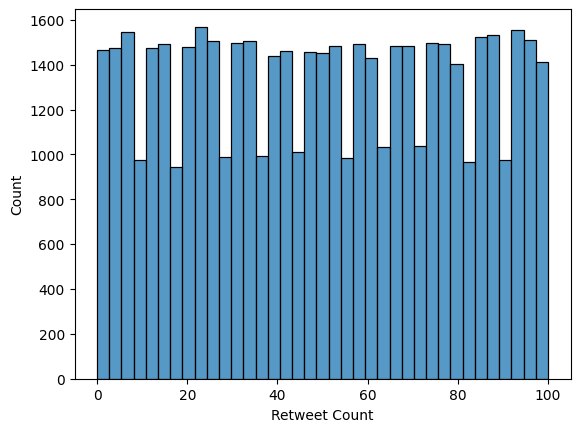

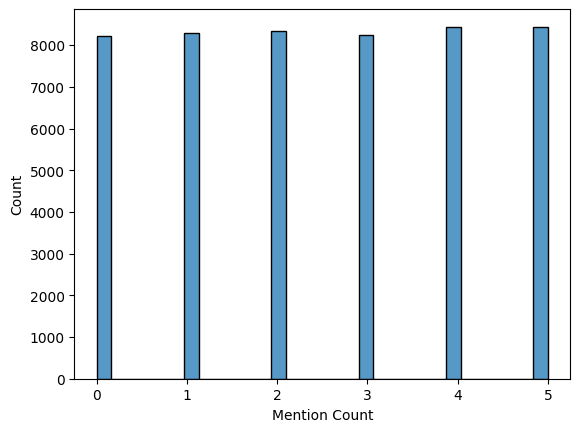

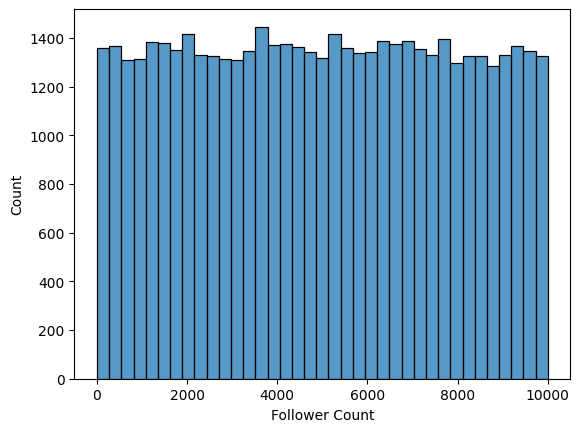

<__array_function__ internals>:180: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


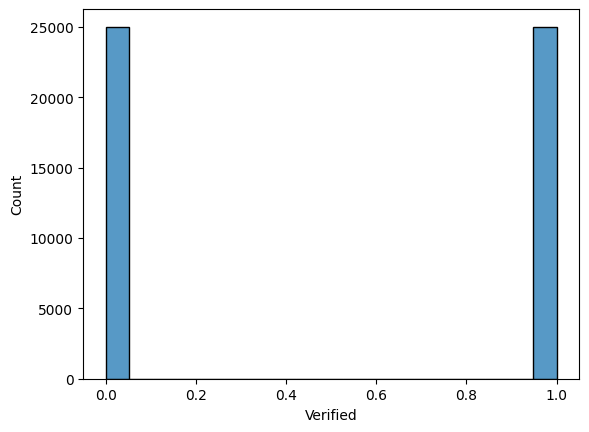

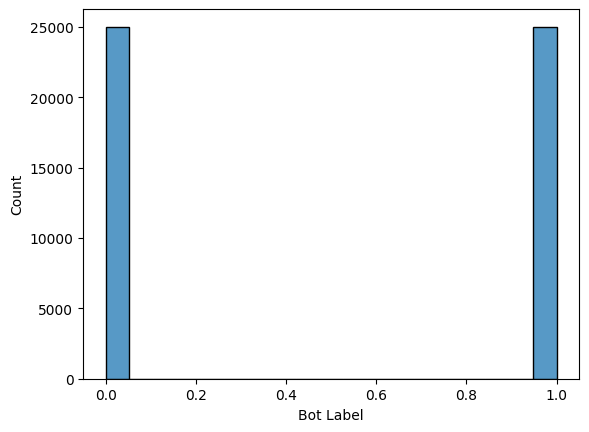

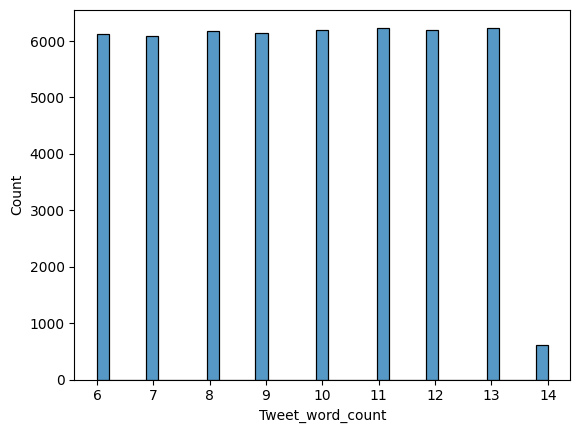

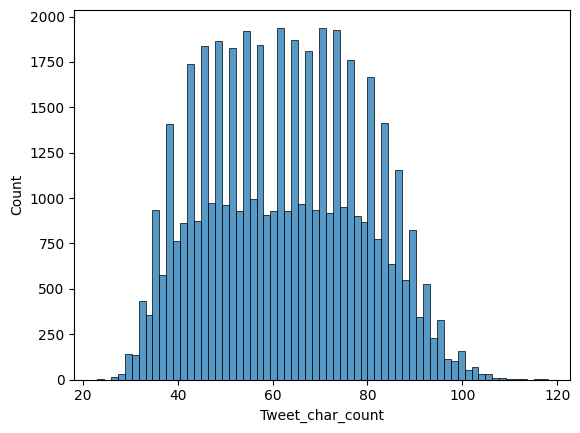

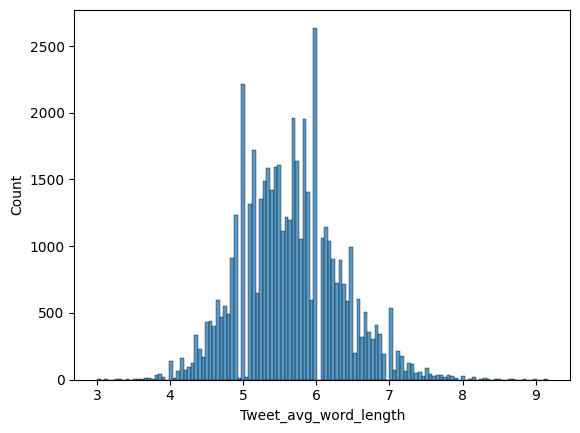

<__array_function__ internals>:180: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


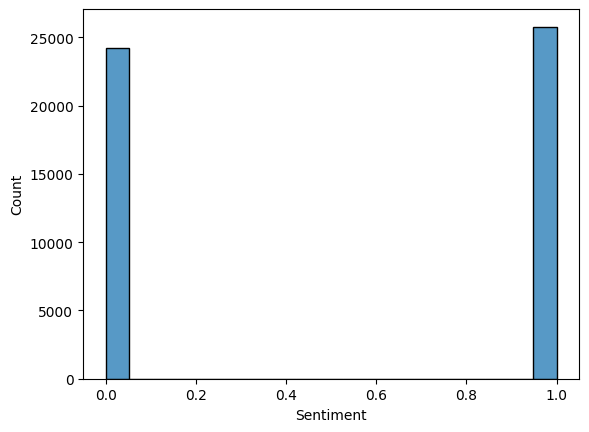

In [106]:
# visualizing distribution of numeric data to check for outliers

visualize_cols = ['Retweet Count', 'Mention Count', 'Follower Count', 'Verified', 'Bot Label', 'Tweet_word_count', 'Tweet_char_count', 'Tweet_avg_word_length', 'Sentiment']

for col in visualize_cols:
    sns.histplot(data=twitter_bot_data, x=col)
    plt.show()

In [107]:
twitter_bot_data.head(5)

,User ID,Username,Tweet,Retweet Count,Mention Count,Follower Count,Verified,Bot Label,Location,Created At,Hashtags,Tweet_word_count,Tweet_char_count,Tweet_avg_word_length,Sentiment
0,132131,flong,Station activity person against natural majori...,85,1,2353,False,1,Adkinston,2020-05-11 15:29:50,NaN,12,83,6.000000,True
1,289683,hinesstephanie,Authority research natural life material staff...,55,5,9617,True,0,Sanderston,2022-11-26 05:18:10,both live,10,77,6.800000,True
2,779715,roberttran,Manage whose quickly especially foot none to g...,6,2,4363,True,0,Harrisonfurt,2022-08-08 03:16:54,phone ahead,10,61,5.200000,False
3,696168,pmason,Just cover eight opportunity strong policy which.,54,5,2242,True,1,Martinezberg,2021-08-14 22:27:05,ever quickly new I,7,49,6.142857,True
4,704441,noah87,Animal sign six data good or.,26,3,8438,False,1,Camachoville,2020-04-13 21:24:21,foreign mention,6,29,4.000000,True


### Select appropriate features for modeling
We want to select features that can be represented numerically.

In [108]:
df_for_model = twitter_bot_data[['Retweet Count', 'Mention Count', 'Follower Count', 'Verified', 'Bot Label', 
                                 'Tweet_word_count', 'Tweet_char_count', 'Tweet_avg_word_length', 'Sentiment']]

In [110]:
df_for_model = df_for_model.replace({True: 1, False: 0})
df_for_model

,Retweet Count,Mention Count,Follower Count,Verified,Bot Label,Tweet_word_count,Tweet_char_count,Tweet_avg_word_length,Sentiment
0,85,1,2353,0,1,12,83,6.000000,1
1,55,5,9617,1,0,10,77,6.800000,1
2,6,2,4363,1,0,10,61,5.200000,0
3,54,5,2242,1,1,7,49,6.142857,1
4,26,3,8438,0,1,6,29,4.000000,1
...,...,...,...,...,...,...,...,...,...
49995,64,0,9911,1,1,9,50,4.666667,0
49996,18,5,9900,0,1,13,86,5.692308,1
49997,43,3,6313,1,1,7,63,8.142857,1
49998,45,1,6343,0,0,10,61,5.200000,0


### More Visualization

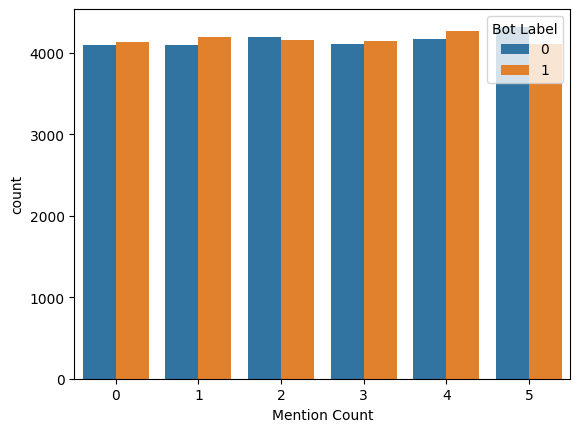

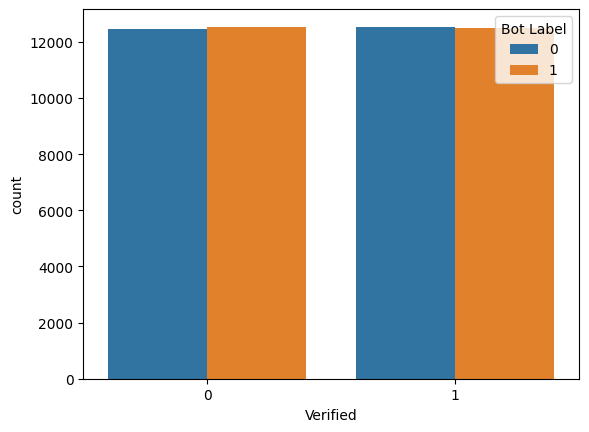

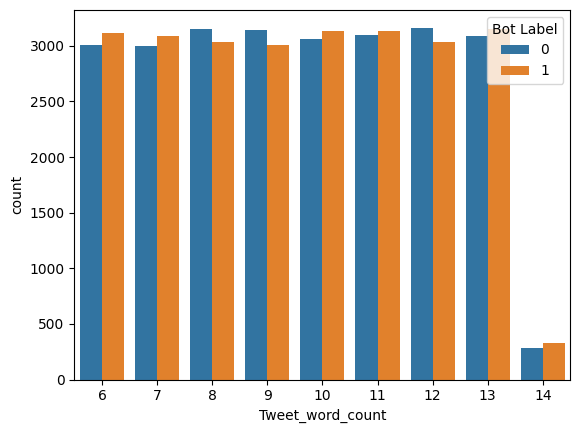

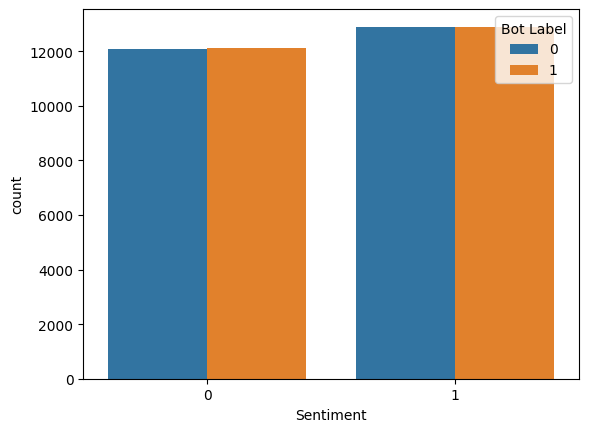

<Figure size 640x480 with 0 Axes>

In [111]:
bivariate_viz = ['Mention Count', 'Verified', 'Tweet_word_count', 'Sentiment']

for col in bivariate_viz:
    sns.countplot(data=df_for_model, x=col, hue='Bot Label')
    plt.show()
    plt.clf()

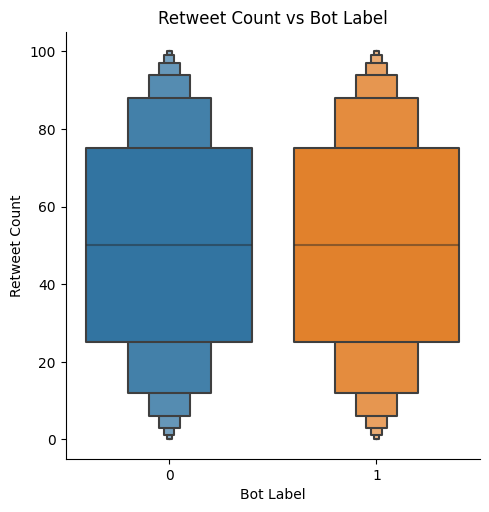

<Figure size 640x480 with 0 Axes>

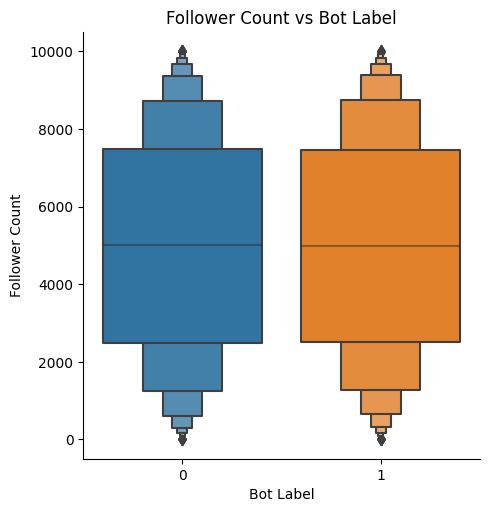

<Figure size 640x480 with 0 Axes>

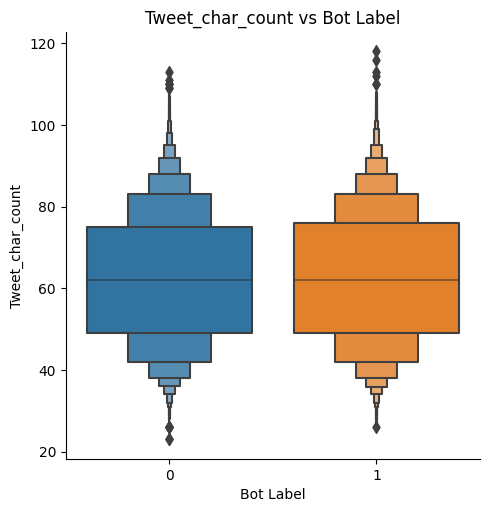

<Figure size 640x480 with 0 Axes>

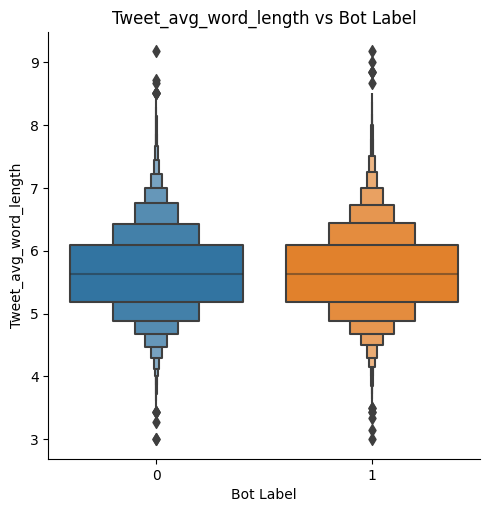

<Figure size 640x480 with 0 Axes>

In [94]:
col_box = ['Retweet Count', 'Follower Count', 'Tweet_char_count', 'Tweet_avg_word_length']

for col in col_box:
    sns.catplot(df_for_model, x='Bot Label', y=col, kind='boxen')
    plt.title(f'{col} vs Bot Label')
    plt.show()
    plt.clf()

### Select target and predictor variables

In [112]:
X = df_for_model.drop(columns=['Bot Label'])
y = df_for_model['Bot Label']

In [113]:
# get summary statistics
X.describe()

,Retweet Count,Mention Count,Follower Count,Verified,Tweet_word_count,Tweet_char_count,Tweet_avg_word_length,Sentiment
count,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,50.00560,2.513760,4988.602380,0.500080,9.571200,62.627340,5.655132,0.515720
std,29.18116,1.708563,2878.742898,0.500005,2.329463,16.471543,0.679950,0.499758
min,0.00000,0.000000,0.000000,0.000000,6.000000,23.000000,3.000000,0.000000
25%,25.00000,1.000000,2487.750000,0.000000,8.000000,49.000000,5.181818,0.000000
50%,50.00000,3.000000,4991.500000,1.000000,10.000000,62.000000,5.625000,1.000000
75%,75.00000,4.000000,7471.000000,1.000000,12.000000,76.000000,6.090909,1.000000
max,100.00000,5.000000,10000.000000,1.000000,14.000000,118.000000,9.166667,1.000000


### Correlation matrix
Predictor variables should not be highly correlated with each other because logistic regression assumes no multicollinearity among variables. 

It looks like the Tweet_word_count and Tweet_char_count are highly correlated, which makes sense. Will need to drop one of these.

In [114]:
correlation_matrix = df_for_model.corr(numeric_only=True)
correlation_matrix = round(correlation_matrix, 2)

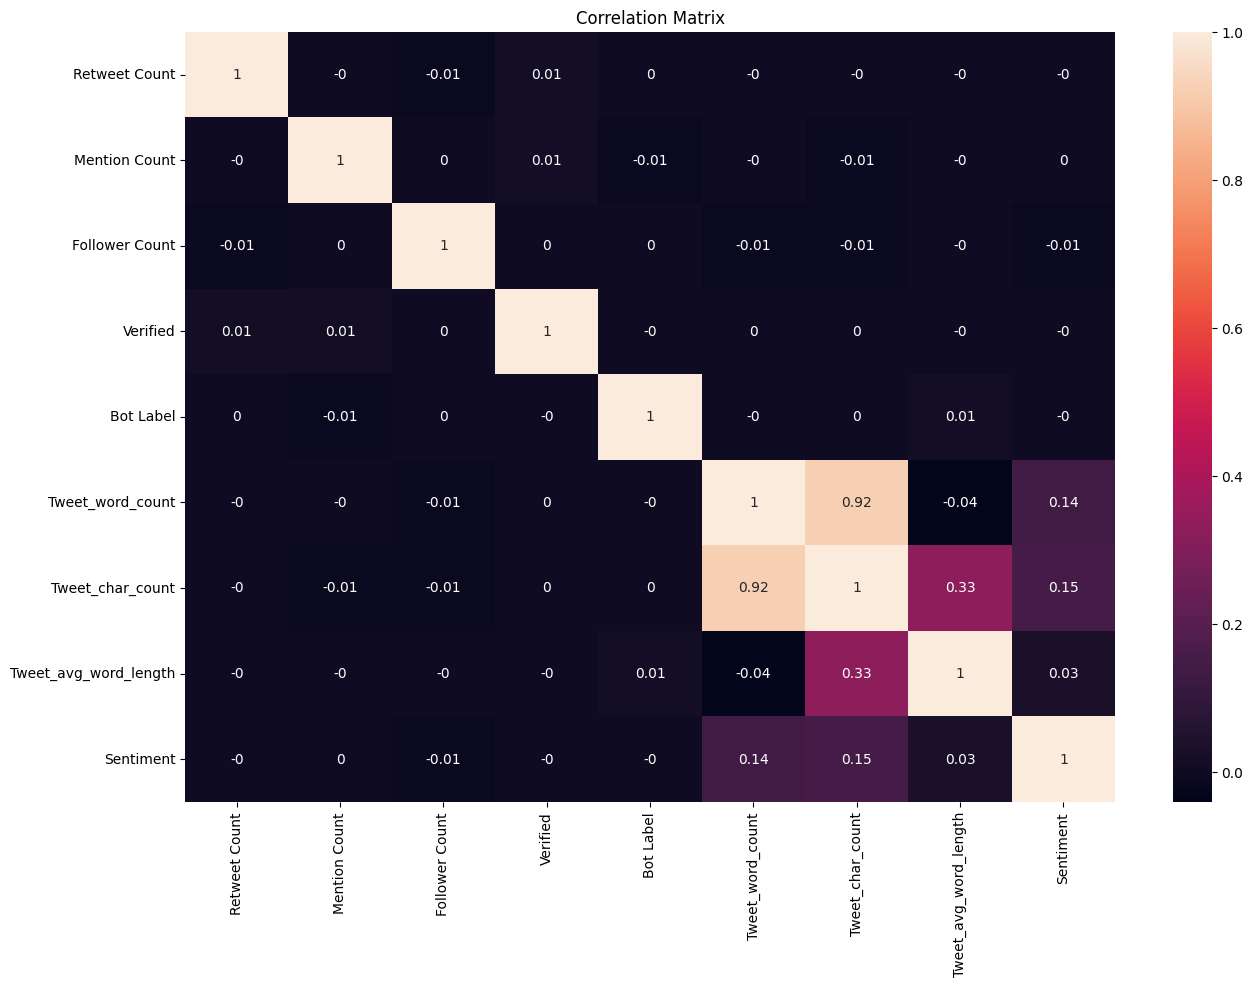

<Figure size 640x480 with 0 Axes>

In [115]:
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=True, )
plt.title('Correlation Matrix')
plt.show()
plt.clf()

### Checking for multicollinearity using VIF method
Values should ideally be less than 5 to indicate there is not an issue with multicollinearity.

SOURCE: https://www.geeksforgeeks.org/detecting-multicollinearity-with-vif-python/

In [117]:
# dropping due to multicollinearity
X = X.drop(columns=['Tweet_char_count'])

# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]
  
print(vif_data)

                 feature        VIF
0          Retweet Count   3.819683
1          Mention Count   3.093759
2         Follower Count   3.872033
3               Verified   1.981175
4       Tweet_word_count  14.695889
5  Tweet_avg_word_length  19.306171
6              Sentiment   2.110478


In [118]:
# dropping due to VIF > 5
X = X.drop(columns=['Tweet_word_count'])

# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]
  
print(vif_data)

                 feature       VIF
0          Retweet Count  3.790799
1          Mention Count  3.078862
2         Follower Count  3.845423
3               Verified  1.976008
4  Tweet_avg_word_length  9.813949
5              Sentiment  2.050119


In [119]:
# still getting a value >5 for average word length
X = X.drop(columns=['Tweet_avg_word_length'])

# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]
  
print(vif_data)

          feature       VIF
0   Retweet Count  2.892292
1   Mention Count  2.563679
2  Follower Count  2.912179
3        Verified  1.827388
4       Sentiment  1.862071


### Checking Linearity of independent variables and log odds using Box-Tidwell Test
Logistic regression assumes there is a linear relationship between the predictor variables and the log odds (or logit) of the target variable. 

SOURCE: https://towardsdatascience.com/assumptions-of-logistic-regression-clearly-explained-44d85a22b290  \
SOURCE: https://stats.oarc.ucla.edu/stata/webbooks/logistic/chapter3/lesson-3-logistic-regression-diagnostics/

In [121]:
X_continuous_numeric = X.drop(columns=['Verified', 'Sentiment'])

# Box Tidwell only works for positive values. Hence, drop values where x = 0
X_bt = X_continuous_numeric[X_continuous_numeric['Retweet Count'] != 0]
X_bt = X_bt[X_bt['Mention Count'] != 0]
X_bt = X_bt[X_bt['Follower Count'] != 0]

X_bt.head()

,Retweet Count,Mention Count,Follower Count
0,85,1,2353
1,55,5,9617
2,6,2,4363
3,54,5,2242
4,26,3,8438


In [64]:
X_bt2 = X_bt.drop(columns='Bot Label')
y_bt = X_bt['Bot Label']

# Add logit transform interaction terms (natural log) for continuous variables e.g. Age * Log(Age)
for col in X_bt2.columns:
    X_bt2[f'{col}:Log_{col}'] = X_bt2[col].apply(lambda x: x * np.log(x)) #np.log = natural log

X_bt2.head()

,Retweet Count,Mention Count,Follower Count,Retweet Count:Log_Retweet Count,Mention Count:Log_Mention Count,Follower Count:Log_Follower Count
0,85,1,2353,377.625357,0.000000,18267.389353
1,55,5,9617,220.403325,8.047190,88200.273279
2,6,2,4363,10.750557,1.386294,36565.932900
3,54,5,2242,215.405139,8.047190,17297.307119
4,26,3,8438,84.710510,3.295837,76283.744001


In [65]:
# Add constant
X_bt_constant = add_constant(X_bt2)
  
# Build model and fit the data (using statsmodel's Logit)
logit_results = GLM(y_bt, X_bt_constant, family=families.Binomial()).fit()

# Display summary results
print(logit_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:              Bot Label   No. Observations:                41326
Model:                            GLM   Df Residuals:                    41319
Model Family:                Binomial   Df Model:                            6
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -28641.
Date:                Sat, 17 Jun 2023   Deviance:                       57282.
Time:                        13:24:36   Pearson chi2:                 4.13e+04
No. Iterations:                     3   Pseudo R-squ. (CS):          0.0001919
Covariance Type:            nonrobust                                         
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

#### Visual check for linear relationship
To perform the box-tidwell test I run a logistic regression model including the variables and the log transformed variables. 
The assumption in logistic regression is that there is a linear relationship between the independent variables and the logit 
of the target variable. The output I am looking for from this box-tidwell test above is that the p-values interaction terms 
will not be statistically significant (which indicates a linear relationship between the variable and the logit).

Looking at the scatterplots, it is easy to see the linear relationships among the variables vs the log odds, meaning the assumptions for linear regression are met.

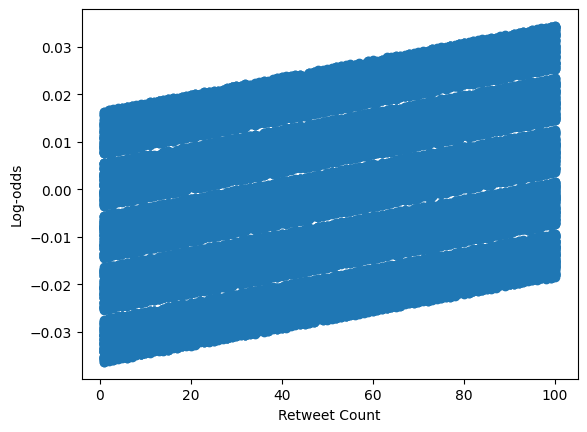

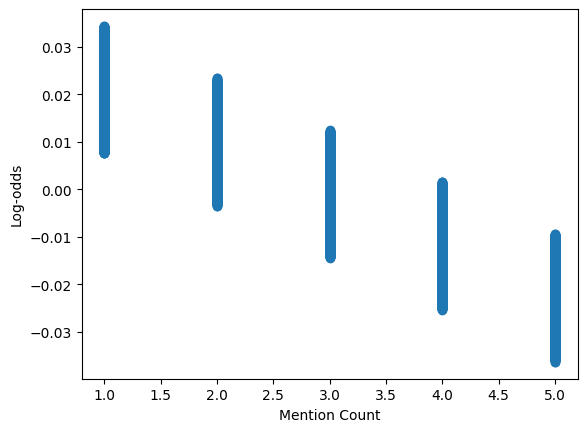

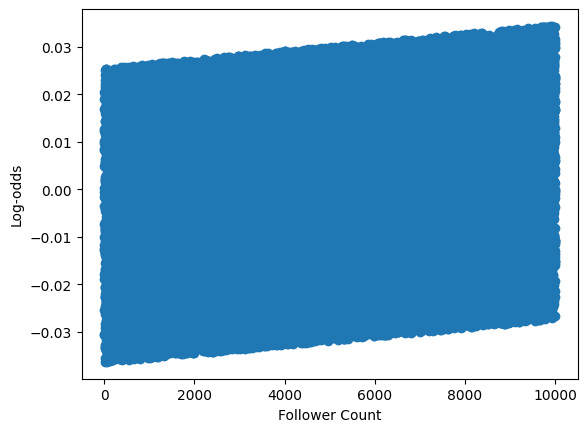

In [71]:
X_bt3 = X_bt.drop(columns='Bot Label')
y_bt3 = X_bt['Bot Label']
# Add constant
X_bt3_constant = add_constant(X_bt3)

# Re-running logistic regression on the original set of X and y variables (not log transformed)
logit_results = GLM(y_bt3, X_bt3_constant, family=families.Binomial()).fit()
predicted3 = logit_results.predict(X_bt3_constant)

# Getting log odds values
log_odds = np.log(predicted3 / (1 - predicted3))


cols = ['Retweet Count', 'Mention Count', 'Follower Count']
for col in cols:
    # Visualize predictor variable vs logit values for Age
    plt.scatter(x=X_bt3_constant[col].values, y=log_odds)
    plt.xlabel(col)
    plt.ylabel("Log-odds")
    plt.show()

### Logistic Regression with Statsmodels
Now that the assumptions for logistic regression are confirmed to be met, we can create a model.

In [208]:
# standardize
scaler = StandardScaler()
cols_to_scale = ['Retweet Count', 'Mention Count', 'Follower Count']
X_scaled = X

for col in cols_to_scale:
    X_scaled[[col]] = scaler.fit_transform(X_scaled[[col]])

# add constant
Xc = add_constant(X_scaled)

# train/test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, train_size = 0.8, test_size=0.2, random_state=42)

# fit logistic regrssion model
model = Logit(y_train, X_train).fit()

Optimization terminated successfully.
         Current function value: 0.693140
         Iterations 3


In [209]:
print(model.summary())

                           Logit Regression Results                           
Dep. Variable:              Bot Label   No. Observations:                40000
Model:                          Logit   Df Residuals:                    39995
Method:                           MLE   Df Model:                            4
Date:                Sun, 18 Jun 2023   Pseudo R-squ.:               1.026e-05
Time:                        07:55:54   Log-Likelihood:                -27726.
converged:                       True   LL-Null:                       -27726.
Covariance Type:            nonrobust   LLR p-value:                    0.9664
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Retweet Count      0.0018      0.010      0.179      0.858      -0.018       0.021
Mention Count     -0.0055      0.010     -0.550      0.583      -0.025       0.014
Follower Count     0.0033      0.010

### Evaluate
SOURCE: https://www.geeksforgeeks.org/logistic-regression-using-statsmodels/

In [210]:
model.pvalues

Retweet Count     0.857966
Mention Count     0.582620
Follower Count    0.741128
Verified          0.933299
Sentiment         0.780191
dtype: float64

In [211]:
# performing predictions on the test dataset
yhat_sm = model.predict(X_test)
prediction_sm = list(map(round, yhat_sm))

# comparing original and predicted values of y
print('Actual values', list(y_test.values))
print('Predictions :', prediction_sm)

Actual values [1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0

### Visualize Confusion Matrix

In [212]:
  # confusion matrix
cm_sm = confusion_matrix(y_test, prediction_sm, normalize='true') 
print ("Confusion Matrix : \n", cm_sm) 
  
# accuracy score of the model
print('Test accuracy = ', accuracy_score(y_test, prediction_sm))

Confusion Matrix : 
 [[0.65378422 0.34621578]
 [0.64348172 0.35651828]]
Test accuracy =  0.5042


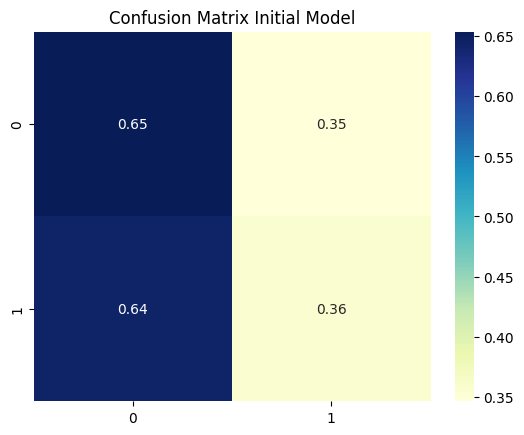

<Figure size 640x480 with 0 Axes>

In [213]:
sns.heatmap(cm_sm, cmap='YlGnBu', annot=True)
plt.title('Confusion Matrix Initial Model')
plt.show()
plt.clf()

### Logistic Regression with Sklearn
We can create the same model type using Sklearn. This option has more hyperparameters that can be tuned.

In [141]:
# build model
log_mod = LogisticRegression(random_state=42, class_weight='balanced', C=1e9, solver='newton-cg', multi_class='multinomial')
log_mod.fit(X_train, y_train)

LogisticRegression(C=1000000000.0, class_weight='balanced',
                   multi_class='multinomial', random_state=42,
                   solver='newton-cg')

### Evaluate
Results are a bit better with this model, but still not getting above 50% accuracy on the train or test set.

In [143]:
#Accuracy on train
print('The training accuracy is: ', log_mod.score(X_train, y_train))

#Accuracy on test
print('The testing accuracy is: ', log_mod.score(X_test, y_test))

#Obtain coefficients
print('The coefficients are: ', log_mod.coef_)

The training accuracy is:  0.501975
The testing accuracy is:  0.4989
The coefficients are:  [[ 0.00089741 -0.00273497  0.00165372 -0.00230415 -0.00392258]]


In [198]:
# performing predictions on the test dataset
yhat_sklearn = log_mod.predict(X_test)
prediction_sklearn = list(map(round, yhat_sklearn))

# comparing original and predicted values of y
print('Actual values', list(y_test.values))
print('Predictions :', prediction_sklearn)

Actual values [1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0

In [199]:
# confusion matrix
cm_sklearn = confusion_matrix(y_test, prediction_sklearn, normalize='true') 
print ("Confusion Matrix : \n", cm_sklearn) 
  
# accuracy score of the model
print('Test accuracy = ', accuracy_score(y_test, prediction_sklearn))

Confusion Matrix : 
 [[0.50060386 0.49939614]
 [0.50278219 0.49721781]]
Test accuracy =  0.4989


### Visualize Confusion Matrix

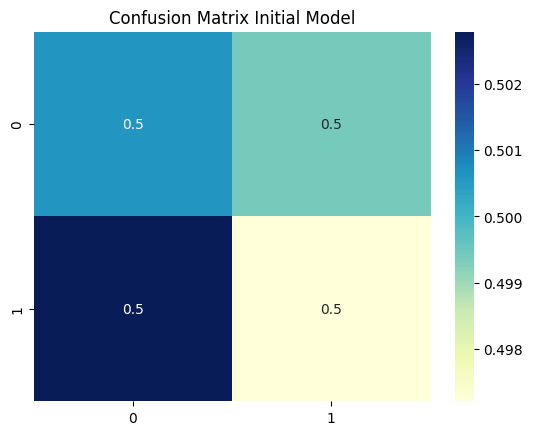

<Figure size 640x480 with 0 Axes>

In [201]:
sns.heatmap(cm_sklearn, cmap='YlGnBu', annot=True)
plt.title('Confusion Matrix Initial Model')
plt.show()
plt.clf()

### Classification Report
This evaluation method shows precision, recall, f1-score, and support.

In [161]:
print(classification_report(y_test, prediction_sklearn, zero_division=0))

              precision    recall  f1-score   support

           0       0.50      0.65      0.57      4968
           1       0.51      0.36      0.42      5032

    accuracy                           0.50     10000
   macro avg       0.51      0.51      0.49     10000
weighted avg       0.51      0.50      0.49     10000



### Log loss (cross-entropy loss) on test data

In [163]:
#log loss on test set
pred_proba = log_mod.predict_proba(X_test)
print('The log loss on testing dataset is: ', log_loss(y_test, pred_proba, normalize='true'))

The log loss on testing dataset is:  0.6930886797299262


### Evaluate feature importance

In [165]:
dt = DecisionTreeClassifier(criterion='entropy', random_state=42, class_weight='balanced', max_depth=10)
dt.fit(X, y)

DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=10, random_state=42)

In [166]:
fi_col = []
fi = []

for i, column in enumerate(X.columns):
    print('The feature importance for {} is {}: '.format(column, dt.feature_importances_[i]))

    fi_col.append(column)
    fi.append(dt.feature_importances_[i])

The feature importance for Retweet Count is 0.3033497541636314: 
The feature importance for Mention Count is 0.08071549209030296: 
The feature importance for Follower Count is 0.5520985161551966: 
The feature importance for Verified is 0.015698914712132396: 
The feature importance for Sentiment is 0.048137322878736594: 


In [167]:
#create feature importance dataframe

fi_df = zip(fi_col, fi)
fi_df = pd.DataFrame(fi_df, columns=['Feature', 'Feature_importance'])

fi_df.sort_values('Feature_importance', ascending=False).reset_index(drop=True)

,Feature,Feature_importance
0,Follower Count,0.552099
1,Retweet Count,0.303350
2,Mention Count,0.080715
3,Sentiment,0.048137
4,Verified,0.015699


### Recursive Feature Selection with Sklearn
This method identifies the features with the least importance and recommends which ones to remove.

In [169]:
#can run this with different values for n_features_to_select to compare outcomes; default will select half the features
rfe = RFE(estimator=DecisionTreeClassifier())
rfe.fit(X, y)

RFE(estimator=DecisionTreeClassifier())

In [170]:
for i, col in zip(range(X.shape[1]), X.columns):
    print(f'{col} selected={rfe.support_[i]} rank={rfe.ranking_[i]}')

Retweet Count selected=True rank=1
Mention Count selected=False rank=2
Follower Count selected=True rank=1
Verified selected=False rank=3
Sentiment selected=False rank=4


In [171]:
cols = []
selected = []
rank = []

# creating a dataframe of results
for i, col in zip(range(X.shape[1]), X.columns):
    cols.append(col)
    selected.append(rfe.support_[i])
    rank.append(rfe.ranking_[i])

RFE_Results_df = pd.DataFrame(zip(cols, selected, rank), columns=['Feature', 'Selected', 'Rank'])

In [172]:
# sort by rank/importance
RFE_Results_df.sort_values('Rank').reset_index(drop=True)

,Feature,Selected,Rank
0,Retweet Count,True,1
1,Follower Count,True,1
2,Mention Count,False,2
3,Verified,False,3
4,Sentiment,False,4


In [173]:
# apply to dataset
rfe.set_output(transform='pandas')
X2 = rfe.transform(X)

### Build final model (with least important features removed)
This method didn't help improve the results, but it was good practice.

In [182]:
#split into train and test set
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y, train_size = 0.8, test_size=0.2, random_state=42)

In [183]:
# build model
log_mod2 = LogisticRegression(random_state=42, class_weight='balanced', C=1e9, solver='newton-cg', multi_class='multinomial')
log_mod2.fit(X_train2, y_train2)

LogisticRegression(C=1000000000.0, class_weight='balanced',
                   multi_class='multinomial', random_state=42,
                   solver='newton-cg')

In [194]:
# performing predictions on the test dataset
yhat_final = log_mod2.predict(X_test2)
prediction_final = list(map(round, yhat_final))

In [195]:
# confusion matrix
cm_final = confusion_matrix(y_test2, prediction_final, normalize='true') 
print ("Confusion Matrix : \n", cm_final) 
  
# accuracy score of the model
print('Test accuracy = ', accuracy_score(y_test2, prediction_final))

Confusion Matrix : 
 [[0.48933172 0.51066828]
 [0.50059618 0.49940382]]
Test accuracy =  0.4944


### Confusion matrix

In [196]:
tn2, fp2, fn2, tp2 = cm_final.ravel()
(tn2, fp2, fn2, tp2)

(0.4893317230273752,
 0.5106682769726248,
 0.5005961844197139,
 0.4994038155802862)

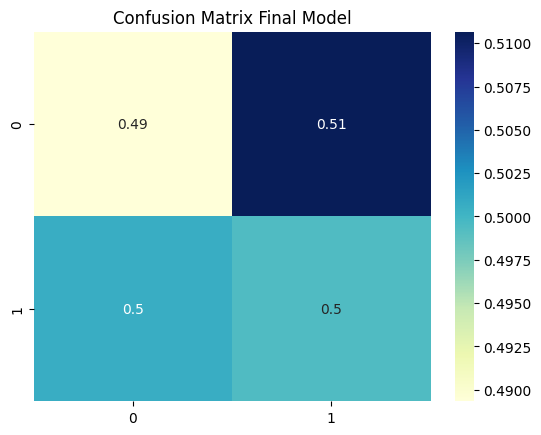

<Figure size 640x480 with 0 Axes>

In [197]:
sns.heatmap(cm_final, cmap='YlGnBu', annot=True)
plt.title('Confusion Matrix Final Model')
plt.show()
plt.clf()

### Evaluate

In [188]:
#Accuracy on train
print('The training accuracy is: ', log_mod2.score(X_train2, y_train2))

#Accuracy on test
print('The testing accuracy is: ', log_mod2.score(X_test2, y_test2))

print(classification_report(y_train2, y_pred2, zero_division=0))

The training accuracy is:  0.500975
The testing accuracy is:  0.4944
              precision    recall  f1-score   support

           0       0.50      0.50      0.50     20014
           1       0.50      0.50      0.50     19986

    accuracy                           0.50     40000
   macro avg       0.50      0.50      0.50     40000
weighted avg       0.50      0.50      0.50     40000



### Get Log Loss

In [189]:
#log loss on training set
print('The log loss on training dataset is: ', log_loss(y_train2, pred_proba2, normalize='true'))

#log loss on test set
pred_proba_t2 = log_mod2.predict_proba(X_test2)
print('The log loss on testing dataset is: ', log_loss(y_test2, pred_proba_t2, normalize='true'))

The log loss on training dataset is:  0.693145439172597
The log loss on testing dataset is:  0.6931476546140564


### Conclusion
We performed logistic regression using both statsmodels and sklearn. Sklearn gave slightly better results, but not good enough to be something useful in predicting whether tweets were made by a bot. Options to improve results could include identifying additional data or features, or using a different model.